In [1]:
from keras.models import Sequential
from keras.layers import Dense,Activation,LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import matplotlib.pyplot as plt

Using TensorFlow backend.
/home/puneet/.local/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
path = get_file('nietzsche.txt', origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = open(path).read().lower()
print('blob length:', len(text))

blob length: 600893


In [3]:
len(set(text))

57

In [4]:
chars = sorted(list(set(text)))
print(chars)
char_idx = dict((c , i) for i,c in enumerate(chars))
idx_char = dict((i , c) for i,c in enumerate(chars))
print(len(list(char_idx.items())))

['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ä', 'æ', 'é', 'ë']
57


In [5]:
text[41:530]

'--what then? is there not ground\nfor suspecting that all philosophers, in so far as they have been\ndogmatists, have failed to understand women--that the terrible\nseriousness and clumsy importunity with which they have usually paid\ntheir addresses to truth, have been unskilled and unseemly methods for\nwinning a woman? certainly she has never allowed herself to be won; and\nat present every kind of dogma stands with sad and discouraged mien--if,\nindeed, it stands at all! for there are sc'

In [6]:
from nltk.tokenize import sent_tokenize
sent1 = sent_tokenize(text)
print(len(sent1))
print(sent1[2])
print("*"*34)
sent = text.split("\n")
print(len(sent))
print(sent[20])

2864
certainly she has never allowed herself to be won; and
at present every kind of dogma stands with sad and discouraged mien--if,
indeed, it stands at all!
**********************************
9935
ego-superstition, has not yet ceased doing mischief): perhaps some


In [7]:
length_sent = list()
for s in sent:
    length_sent.append(len(s))
print(len(length_sent))

9935


In [8]:
uniq , cnt = np.unique(np.array(length_sent),return_counts=True)
print(len(uniq),len(cnt))
uniq[1:10],cnt[1:10]

73 73


(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([17, 90, 46,  3,  6,  6,  7,  9, 14]))

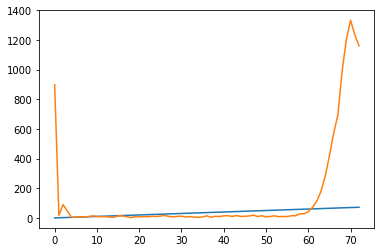

In [9]:
plt.plot(uniq)
plt.plot(cnt)
plt.show()

In [10]:
maxlen = 50
step = 3
sentences = list()
next_chars = list()

for i in range(0,len(text)-maxlen,step):
    sentences.append(text[i:i+maxlen])
    next_chars.append(text[i+maxlen])
    
print(len(sentences))

200281


In [11]:
# for i in range(0, len(text) - maxlen, step):
#     print(i,end=",")
print(sentences[5],end=", ")
print(next_chars[5])
print(sentences[6],end=", ")
print(next_chars[6])

sing that truth is a woman--what then? is there no, t
g that truth is a woman--what then? is there not g, r


### Vectorization

In [12]:
X = np.zeros((len(sentences), maxlen , len(chars)) , dtype = np.bool)
Y = np.zeros((len(sentences),len(chars)),dtype = np.bool)

for i , sentence in enumerate(sentences):
    for t , char in enumerate(sentence):
        X[i,t,char_idx[char]] = 1
        
    Y[i,char_idx[next_chars[i]]] = 1

## Model Architecture

In [13]:
model = Sequential()
model.add(LSTM(128,input_shape=(maxlen,len(chars))))
model.add(Dense(len(chars),activation="sigmoid"))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               95232     
_________________________________________________________________
dense_1 (Dense)              (None, 57)                7353      
Total params: 102,585
Trainable params: 102,585
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Dense?
# len(chars)

In [15]:
optimizer = RMSprop(lr = 0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### Smoothing Probability

In [16]:
def sampling(pred , temp = 1):
    pred = np.array(pred).astype("float64")
    pred = np.log(pred)/temp
    
    exp_pred = np.exp(pred)
    pred = exp_pred / np.sum(exp_pred)
    
    prob = np.random.multinomial(1,pred,1)
    return np.argmax(prob)

In [17]:
np.random.multinomial?

### Training Model

In [18]:
# char = sorted(list(set(text)))
# len(char)

In [19]:
for iteration in range(1, 10):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(X, Y, shuffle=True,
              batch_size=128,
              epochs=1, verbose=2)

    start_index = random.randint(0, len(text) - maxlen - 1)
    div = [0.2, 0.5, 1.0, 1.2]
    for diversity in div:
        print()
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_idx[char]] = 1.

            preds = model.predict(x, verbose=0)[0]
#             print(len(preds))
            next_index = sampling(preds, diversity)
            next_char = idx_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()


--------------------------------------------------
Iteration 1
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
 - 165s - loss: 2.0555 - acc: 0.3962

----- diversity: 0.2
----- Generating with seed: "ertain that the jews, if they desired--or if they
"
ertain that the jews, if they desired--or if they
in the inder the still the and 

/home/puneet/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


and there is and and the its the most the most to the interch and the the still as and and and and and the inder all the other and the the strenged what all and and there is the man of the strantion and the strange the inder and the in the man its and and and the stranges the strange the most and the most and and the most and the will the most and and the still and t

----- diversity: 0.5
----- Generating with seed: "ertain that the jews, if they desired--or if they
"
ertain that the jews, if they desired--or if they
here there aboot and which his mort also its instinct the gain to this its art the stild this for it of there far as its enjorture in the resso the there as a
man, for such all a no the in the man, strautions of his still contares is of this is also and the there there is his nature of the the frien and who have what of which for moral to the most as can it is
all-he a could perhaps and has the th

----- diversity: 1.0
----- Generating with seed: "ertain that the jews, if 

nourish, know the dangerous dyspepsia                                                                                                                                                                                                                                                                                                                                                                                                                 

----- diversity: 1.2
----- Generating with seed: "ifficult to
nourish, know the dangerous dyspepsia "
ifficult to
nourish, know the dangerous dyspepsia                                                                                                                                                                                                                                                                                                                                                                                                                 

------

                                                                                                                                                                                                                                                                                                                                                                                                                

----- diversity: 0.5
----- Generating with seed: "in this art affords presence of mind in difficult
"
in this art affords presence of mind in difficult
                                                                                                                                                                                                                                                                                                                                                                                                                

----- diversity: 1.0
----- Generating with s